## Libraries Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from random import randint
from matplotlib import rcParams

## Load Data Function

In [2]:
def load_data(start_year, end_year, parameter):
    year = start_year - 1
    size = (end_year - start_year + 1) * 12
    month = 1
    x = [[]for i in range (size)]
    for i in range(0, size):
        year = year + 1 if ((i + 1) % 12) == 1 else year
        ms = '0' + str(month) if month<10 else str(month)
        filename = 'v' + parameter + str(year) + ms + '01' + '.txt'
        path = path = '~/Documents/Tesis/Data/' + parameter + '/' + str(year) + '/'
        x[i] = pd.read_csv(path + filename, header=None)
        month = month + 1 if month < 12 else 1
    return x

## Get Latitude and Longitude Functions

In [3]:
def findItem(theList, item):
    pos_list = [[ind, theList[ind].index(item)] for ind in range(len(theList)) if item in theList[ind]]
    return [pos_list[0][0], pos_list[0][1]]

def find_step(start, end, abs_step):
    act_step = abs(abs_step) if start < end else -abs(abs_step)
    return act_step

def create_list(start_lat, end_lat, start_lon, end_lon, lat_step, lon_step):
    lat = np.arange(start_lat, end_lat + lat_step, lat_step).tolist()
    lon = np.arange(start_lon, end_lon + lon_step, lon_step).tolist()
    grid = [[[]for i in range(len(lon))] for j in range(len(lat))]
    y = 0
    for i in range(0, len(lat)):
        for j in range(0, len(lon)):
            grid[i][j] = y
            y += 1
    return grid, lat, lon

def get_ll(index, grid, lat, lon):
    return lat[findItem(grid, index)[0]], lon[findItem(grid, index)[1]]

def get_index(latitude, longitude, lat, lon):
    return grid[lat.index(latitude)][lon.index(longitude)]

# print(get_ll(619683))
# print(get_index(-30.75,14))

## ARIMA Function

In [202]:
def arima_model(data, numpr):
    X = data
    actual_size = len(data)
    train_size = int(0.75*len(data))
    train = X[0:train_size]
    test = X[train_size - 1:]
    
    best_aic = 99999
    p=(3,4,6)
    d=range(0,1)
    q=range(1,5)
    pdq = list(itertools.product(p, d, q))
    
    warnings.filterwarnings('ignore')
    for param in pdq:
        try:
            model_arima = ARIMA(train, order = param)
            model_arima_fit = model_arima.fit()
            aic = model_arima_fit.aic
            print(param, aic)
            if aic < best_aic:
                best_aic = aic
                best_pdq = param
                best_fit = model_arima_fit
        except:
            continue    
    
    model_arima = ARIMA(train, order=best_pdq)
    # model_arima_fit = model_arima.fit()
    aic = best_fit.aic
    predictions = best_fit.forecast(steps=(actual_size - train_size + 1 + numpr))[0]
    mse = mean_squared_error(test, predictions[0:len(test)])
    return predictions, train, test, aic, mse, best_pdq

## Data Loading

In [5]:
start_time = time.time()
tcwv_data = load_data(1979, 2019, 'tcwv')
print("--- %s seconds ---" % (time.time() - start_time))

--- 130.62685704231262 seconds ---


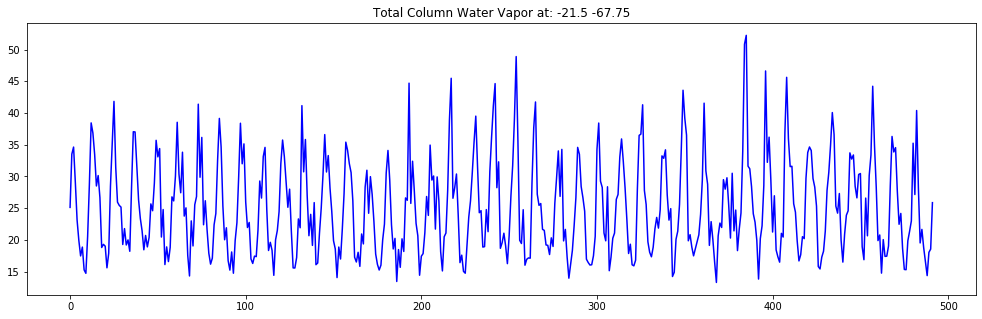

In [214]:
tcwv_values = [0] * (len(tcwv_data))
pos = randint(0, 1038239)
for i in range(len(tcwv_data)):
    tcwv_values[i] = tcwv_data[i][0].values[pos]

start_lat = 90
end_lat = -90
start_lon = 0
end_lon = 359.75
step = 0.25
lat_step = find_step(start_lat, end_lat, step)
lon_step = find_step(start_lon, end_lon, step)
    
lists = create_list(start_lat, end_lat, start_lon, end_lon, lat_step, lon_step)
grid_list = lists[0]
lat_list = lists[1]
lon_list = lists[2]
rcParams['figure.figsize'] = 17, 5

plt.plot(tcwv_values, 'b')
latstr = str(get_ll(pos, grid_list, lat_list, lon_list)[0])
lonstr = str(get_ll(pos, grid_list, lat_list, lon_list)[1] - 180)
# print('At position:', latstr, lonstr)
title = 'Total Column Water Vapor at: ' + latstr + ' ' + lonstr
plt.title(title)
# plt.savefig('figure.png')
plt.show()

(3, 0, 1) 2171.0346000224363
(3, 0, 4) 2067.167143283335
(4, 0, 1) 2167.8813727049737
(4, 0, 2) 2068.4449634608754
(4, 0, 3) 2069.436744067117
(4, 0, 4) 2083.589115617391
(6, 0, 1) 2154.384234075677
(6, 0, 2) 2091.160076660395
(6, 0, 4) 2090.4801422484675


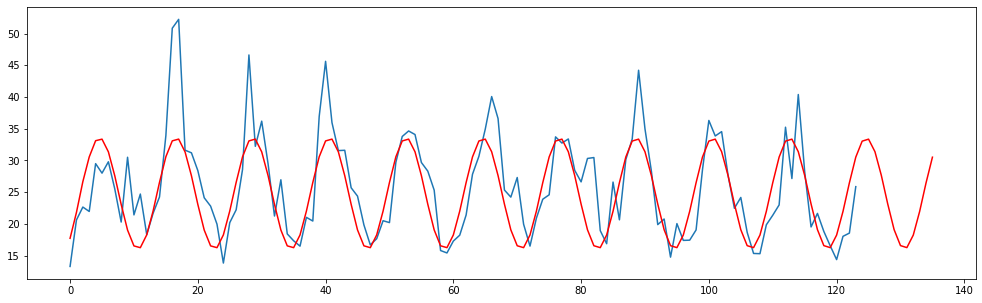

P, D, Q (3, 0, 4)
AIC: 2067.167143283335
MSE: 27.751963594363136


In [215]:
arima_func = arima_model(tcwv_values, 12)
predictions = arima_func[0]
train = arima_func[1]
test = arima_func[2]
aic = arima_func[3]
mse = arima_func[4]
best_pdq = arima_func[5]
str_i = 'AIC: ' + str(aic) + '\nMSE: ' + str(mse)

plt.plot(test)
plt.plot(predictions, 'r')
plt.show()

print('P, D, Q', best_pdq)
print(str_i)

In [164]:


warnings.filterwarnings('ignore')
for param in pdq:
    try:
        model_arima = ARIMA(train, order = param)
        model_arima_fit = model_arima.fit()
        aic = model_arima_fit.aic
        print(param, aic)
        if aic < best_aic:
            best_aic = aic
            best_pdq = param
    except:
        continue

print('Best AIC', best_aic, 'Found at', best_pdq)

(3, 0, 0) -430.70920706734614
Best AIC -430.70920706734614 Found at (3, 0, 0)


In [ ]:
def find_lat(lat_list, any_lat, step):
    lat = min(lat_list, key=lambda x: abs(x - any_lat))
    if any_lat - lat < 0:
        lat_t = lat
        lat_b = lat - step
    else:
        lat_t = lat + step
        lat_b = lat
    return lat_b, lat_t

def find_lon(lon_list, any_lon, step):
    any_lon = any_lon + 180
    lon = min(lon_list, key=lambda x: abs(x - any_lon))
    if any_lon - lon < 0:
        lon_r = lon
        lon_l = lon - step
    else:
        lon_r = lon + step
        lon_l = lon
    return lon_l - 180, lon_r - 180

cv_lat = find_lat(lat_list, 17.36, step)
cv_lon = find_lon(lon_list, -61.29, step)
print('Bottom Latitude', cv_lat[0], 'Top Latitude', cv_lat[1])
print('Left Longitude', cv_lon[0], 'Right Longitude', cv_lon[1])

In [145]:
c = 99999
pos = 0
for i in range(1,7):
    b = randint(1,6)
    if b < c:
        c = b
        pos = i
    print('Run n', i, 'Random Number', b, 'Best number is', c, 'Found at run n', pos)

Run n 1 Random Number 3 Best number is 3 Found at run n 1
Run n 2 Random Number 2 Best number is 2 Found at run n 2
Run n 3 Random Number 3 Best number is 2 Found at run n 2
Run n 4 Random Number 4 Best number is 2 Found at run n 2
Run n 5 Random Number 2 Best number is 2 Found at run n 2
Run n 6 Random Number 1 Best number is 1 Found at run n 6
